In [1]:
#Dice loss 
from keras import backend as K
def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
#IoU
# from keras import backend as K
# def iou(y_true, y_pred, smooth = 1):


Using TensorFlow backend.


**Create Train generator and val generator**

In [2]:
from keras.preprocessing.image import ImageDataGenerator
def adjustData(img,mask, num_class = 23):
  img = img.astype(np.float32)
  img/= 255.0
  new_mask = np.zeros((mask.shape[0],mask.shape[1], mask.shape[2], num_class))
  for i in range(mask.shape[0]):
    this_mask = mask[i,:,:,0]
    for c in range(num_class):
      new_mask[i,:,:,c] = (this_mask == c).astype('int')
    return img, new_mask
def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "rgb",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 23,save_to_dir = None,target_size = (256,256),seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
       
        img,mask = adjustData(img,mask,num_class)
        yield (img,mask)
def valGenerator(val_path,image_folder = 'image', mask_folder= 'mask' ,num_class = 23,image_color_mode = 'rgb',mask_color_mode = 'grayscale',
                  batch_size = 5,target_size = (256,256),as_gray = True, seed = 1):
  
  image_datagen = ImageDataGenerator()
  mask_datagen  = ImageDataGenerator()
  image_generator = image_datagen.flow_from_directory(val_path, 
                                                      classes = [image_folder],
                                                      color_mode = image_color_mode,
                                                      class_mode = None,
                                                      target_size = target_size,
                                                      batch_size = batch_size,
                                                      seed = seed)
  mask_generator = mask_datagen.flow_from_directory(val_path, 
                                classes = [mask_folder],
                                color_mode = mask_color_mode, 
                                class_mode = None, 
                                target_size = target_size,
                                batch_size = batch_size,
                                seed = seed
                                )
  val_generator = zip(image_generator, mask_generator)
  for (img,mask) in val_generator:
    img,mask = adjustData(img, mask, num_class = num_class)
    yield (img, mask)




In [3]:
args = dict(rotation_range = 0.05, width_shift_range = 0.05,height_shift_range = 0.05,
            shear_range=0.05, zoom_range = 0.05)
#args = dict()
train_generator_ = trainGenerator(10, '/content/drive/My Drive/data/train/', 'image','mask', args,num_class = 23 ,image_color_mode='rgb', target_size = (256,256) )
val_generator_ = valGenerator('/content/drive/My Drive/data/test/','image', 'mask',23 , image_color_mode='rgb', target_size = (256,256)) 

**download VGG16**

In [4]:
from keras.applications.vgg16 import VGG16 as vgg16
encoder = vgg16(input_shape = (256,256,3),include_top = False, weights = 'imagenet')
#CONTRACTING PATH
encoder.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

**Create Unet with VGG16 encoder**

In [5]:
from keras.models import *
from keras.layers import *
from keras.applications.vgg16 import VGG16 as vgg16
from keras.metrics import MeanIoU as iou
def pretrained_encoder_unet( input_shape = (256,256,3)):
  encoder = vgg16(input_shape =input_shape,include_top = False, weights = 'imagenet')
  #CONTRACTING PATH
  #input (256,256,3)
  inputs = encoder.layers[0].output
  block1_conv1 = encoder.layers[1].output
  block1_conv2 = encoder.layers[2].output
  block1_pool = encoder.layers[3].output
  #(128,128,64)
  block2_conv1 = encoder.layers[4].output
  block2_conv2 = encoder.layers[5].output
  block2_pool = encoder.layers[6].output
  #(64,64,128)
  block3_conv1 = encoder.layers[7].output
  block3_conv2 = encoder.layers[8].output
  block3_conv3 = encoder.layers[9].output
  block3_pool = encoder.layers[10].output
  #(32,32,256)
  block4_conv1 = encoder.layers[11].output
  block4_conv2 = encoder.layers[12].output
  block4_conv3 = encoder.layers[13].output
  block4_pool = encoder.layers[14].output
  #(16,16,512)


  #EXPANSIVE PART
  #(16,16,512)

  up1 =Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(block4_pool) 
  #(32,32,256)
  up1 = concatenate([up1, block4_conv3])# up1(32,32,256)  concatenate with (32,32,512)  = (32,32,768)
  conv1 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up1) # (32,32,256)
  drop1 = Dropout(0.0)(conv1)
  conv1 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(drop1)
  conv1 = BatchNormalization()(conv1)
  #(32,32,256)
  up2 = Conv2DTranspose(128, (2,2), strides = (2,2), padding = 'same')(conv1)
  #(64,64,128)
  up2 = concatenate([up2, block3_conv3 ]) # up2(64,64,128) concatenate with (64,64,512) = (64,64,640)
  conv2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
  #(64,64,128)
  drop2 = Dropout(0.0)(conv2)
  conv2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(drop2)
  conv2 = BatchNormalization()(conv2)
  #(64,64,128)
  up3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv2)
  #(128,128,64)
  up3 = concatenate([up3,block2_conv2]) #up3(128,128,64) concatenate with (128,128,256) = (128,128,320)
  conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up3)
  drop3 = Dropout(0.0)(conv3)
  conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(drop3)
  conv3 = BatchNormalization()(conv3)
  #(128,128,64)
  up4 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv3)
  #(256,256, 32)
  up4 = concatenate([up4,block1_conv2 ]) #up4(256,256,32) concatenate with (256,256,128) = (256,256,160)
  conv4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up4)
  drop4 = Dropout(0.0)(conv4)
  conv4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(drop4)
  conv4 = BatchNormalization()(conv4)
  #(256,256,32)
  #up5 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv4)
  #(512,512,23)
  #up5 = concatenate([up5,encoder.layers[2].output]) #up5(512,512,16) concatenate with (512,512,64) = (512,512,80)
  #conv5 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up5)
  #drop5 = Dropout(0.1)(conv5)
  #conv5 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(drop5)

  #(512,512,32)

  outputs = Conv2D(23,(3,3), activation = 'softmax', padding = 'same')(conv4)
  model = Model(input= [inputs], output = [outputs])
  for i, layer in enumerate(model.layers):
    if i< 15:
      model.layers[i].trainable = False
  model.compile(optimizer ='adam', loss = 'categorical_crossentropy', metrics = ['accuracy', iou(num_classes= 23)])
  model.summary()
  return model

In [6]:
unet = pretrained_encoder_unet()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


In [7]:
from keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint(filepath = '/content/model.ckpt',
                                   save_weights_only =True,
                                   monitor = 'val_accuracy',
                                   mode = 'max',
                                   save_best_only =  True)

In [ ]:

history = unet.fit(train_generator_, epochs =5,steps_per_epoch= 100, 
                              callbacks = [model_checkpoint], validation_data = val_generator_, validation_steps = 10)



Epoch 1/5
Found 50 images belonging to 1 classes.
Found 50 images belonging to 1 classes.
 26/100 [======>.......................] - ETA: 11:11 - loss: 0.2403 - accuracy: 0.0537 - mean_io_u: 0.4980

**Show an image in train generator and its mask**

Found 350 images belonging to 1 classes.
Found 350 images belonging to 1 classes.


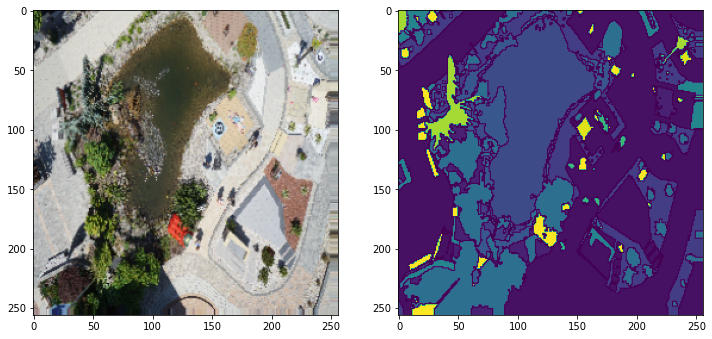

In [8]:
import matplotlib.pyplot as plt
import numpy as np
b = next(train_generator_)

fig, axis = plt.subplots(1,2,figsize = (12,9))
axis[0].imshow(b[0][0,:,:,:,])
axis[1].imshow(np.argmax(b[1][0,:,:,:,], axis = 2))